# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [163]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from fancyimpute import KNN

import warnings
warnings.filterwarnings('ignore')

In [120]:
cars = pd.read_csv(filepath_or_buffer='./data/vehicles.csv')
print(cars.info())
print(cars.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

#### Business Details and Activity Details

**Business**: Here we are dealing with used car data which consists of selling used cars which are categorized by many groups such as type, drive, cylinders, year, transmission and plethora of other categories as seen above.

**Activity Goal:** The goal of this activity is to identify the driving factors of car prices. The data set we have consists of 426880 rows and 17 features. The price prediction should be based on one of many regression models available in machine learning. The selection of a regression model depends on how accurate the model predicts which is calculated based on mean squared error.  

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

#### Basic Data Cleansing by eliminating id column and duplicates

The ID column provided in the data set doesn't add value to our use case here. Hence, we are deleting the ID column. 

Also, there are about 56202 duplicate rows in the data as can be seen below. It is imperative that we delete the duplicate data in order for our model to predict accurately. 

In [121]:
print("Number of rows in original dataset: ", len(cars))
cars.drop('id', inplace=True, axis=1)
print("Number of duplicates:", len(cars[cars.duplicated()]))
cars = cars.drop_duplicates()
print("Number of rows remaining after removing duplicates", len(cars))

Number of rows in original dataset:  426880
Number of duplicates: 56202
Number of rows remaining after removing duplicates 370678


#### Identify the number of null values in each feature.

In [122]:
cars.isnull().sum()

region               0
price                0
year               987
manufacturer     15228
model             4685
condition       141281
cylinders       150758
fuel              2468
odometer          3489
title_status      6772
transmission      2069
VIN             143069
drive           112507
size            264889
type             78893
paint_color     108819
state                0
dtype: int64

**Null Value Observation and probably steps to handle them** 

The number of nulls in the data can be seen from the above table.
There are some features with too many null values and there are few features with only a few null values. There are two things we can do with those null values.
1. Eliminate them completely, hoping it wouldn't impact our modeling as much and/or
2. Impute them with appropriate values using various techniques and libraries.

**Showing Null values graphically.**

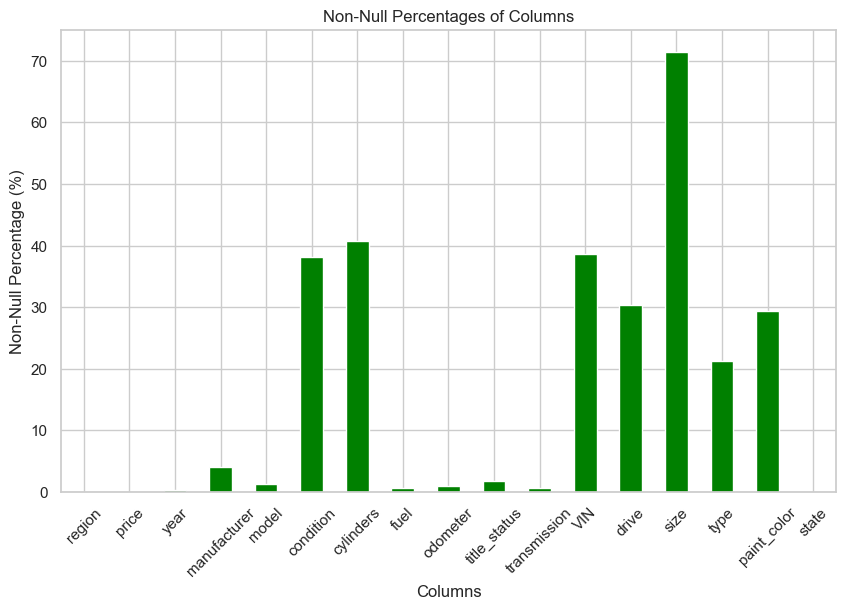

In [123]:
# Calculate the percentage of non-null values for each column
null_percentages = (cars.isnull().mean()) * 100

# Create a bar chart for non-null percentages
null_percentages.plot(kind='bar', rot=0, figsize=(10, 6), color='green')
plt.title('Non-Null Percentages of Columns')
plt.xlabel('Columns')
plt.ylabel('Non-Null Percentage (%)')
plt.xticks(rotation=45)
plt.show()

**Categorical Columns Observation**
Below are the categorical columns of interest that are present in the data set and their unique values. 

In [124]:
interestedCols =['manufacturer', 'condition', 'cylinders', 'title_status', 'transmission', 'fuel', 'drive', 'size', 'type', 'paint_color'] 
for column in interestedCols:
    unique_values = cars[column].unique()
    print(f"Unique values in {column}:\n{unique_values}")
    print('\n')

Unique values in manufacturer:
[nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia' 'rover'
 'ferrari' 'mini' 'pontiac' 'fiat' 'tesla' 'saturn' 'mercury'
 'harley-davidson' 'datsun' 'aston-martin' 'land rover' 'morgan']


Unique values in condition:
[nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']


Unique values in cylinders:
[nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']


Unique values in title_status:
[nan 'clean' 'rebuilt' 'lien' 'salvage' 'missing' 'parts only']


Unique values in transmission:
[nan 'other' 'automatic' 'manual']


Unique values in fuel:
[nan 'gas' 'other' 'diesel' 'hybrid' 'electric']


Unique values in drive:
[nan 'rwd' '4wd' 'fwd']


Unique values in size:
[nan 'full

**More plots to understand data**

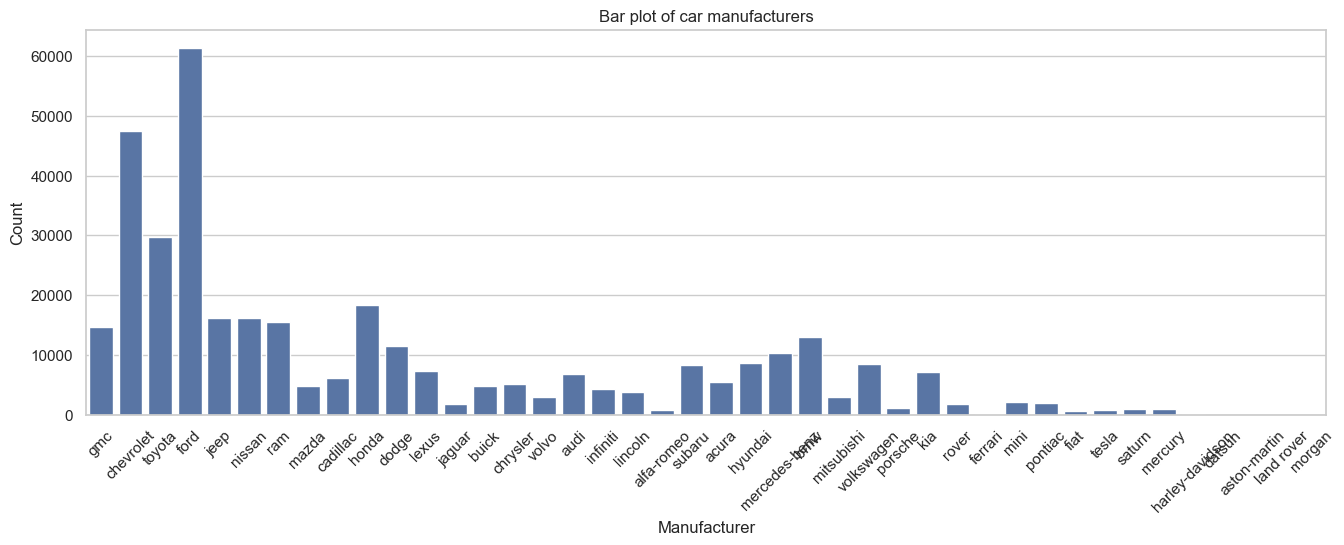

In [125]:
plt.figure(figsize=(16, 5))  # Adjust the width and height as needed
sns.countplot(data=cars, x='manufacturer').set(title='Bar plot of car manufacturers')
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

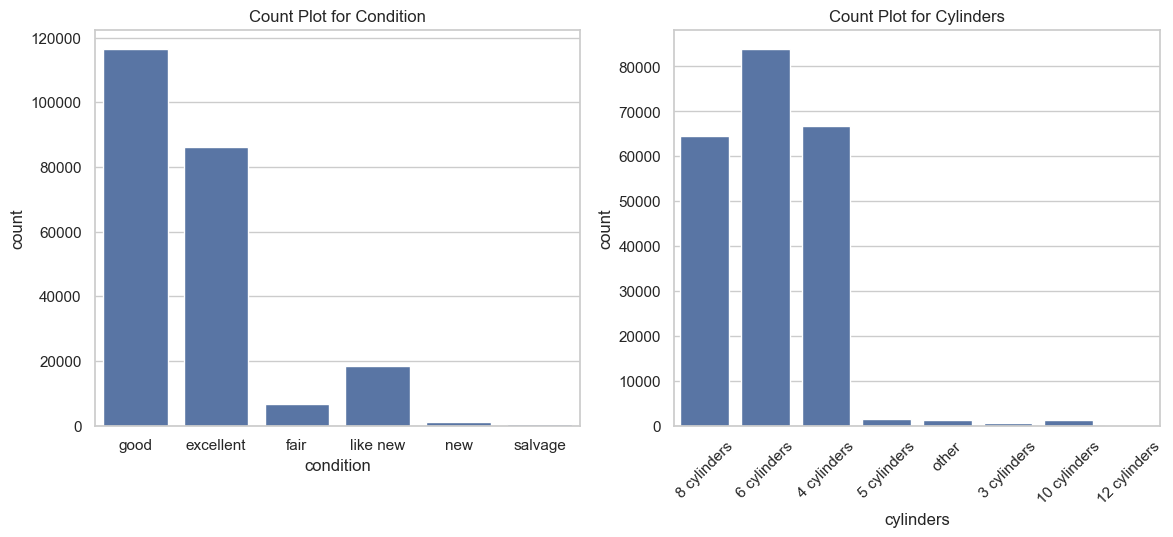

In [126]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='condition', data=cars, ax=axes[0])
axes[0].set_title('Count Plot for Condition')
sns.countplot(x='cylinders', data=cars, ax=axes[1])
axes[1].set_title('Count Plot for Cylinders')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The above graph shows the dataset has a lot of used cars compared to new or salvage cars. Since the objective is to find used car prices, new and salvage cars data could be filtered out. 

<Figure size 1600x1000 with 0 Axes>

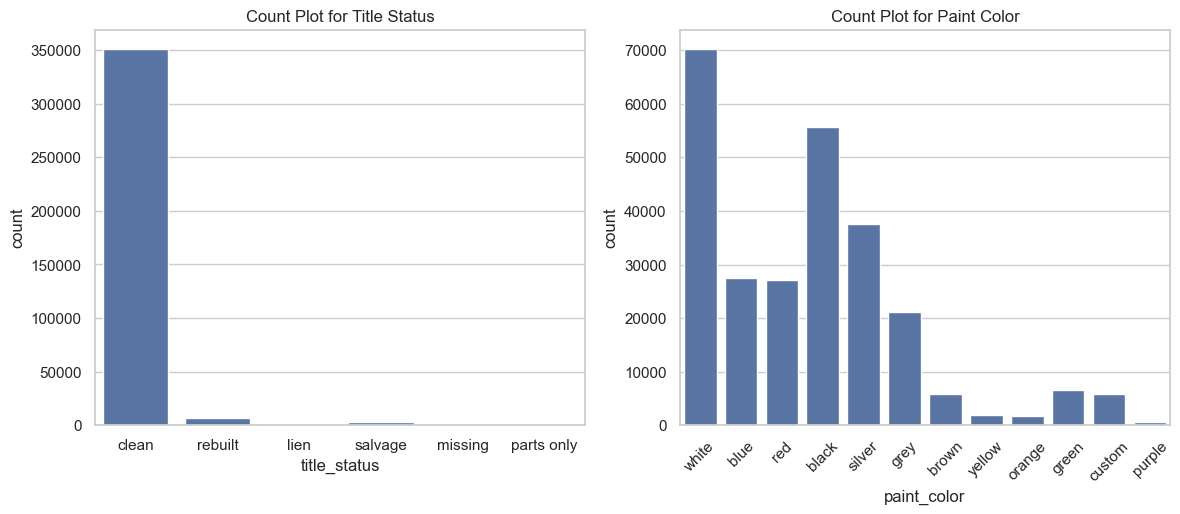

In [127]:
plt.figure(figsize=(16, 10))
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='title_status', data=cars, ax=axes[0])
axes[0].set_title('Count Plot for Title Status')
sns.countplot(x='paint_color', data=cars, ax=axes[1])
axes[1].set_title('Count Plot for Paint Color')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

fuel
diesel       25930
electric      1595
gas         307783
hybrid        4684
other        28218
dtype: int64


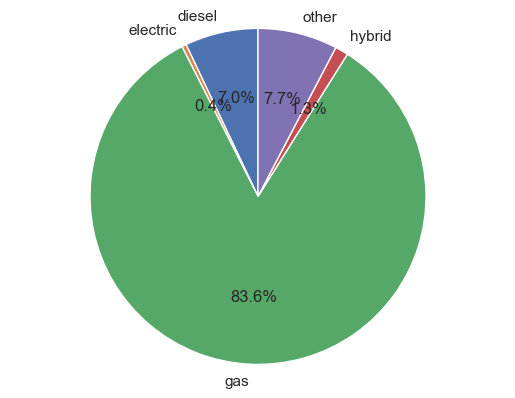

['diesel', 'electric', 'gas', 'hybrid', 'other']


In [128]:
data = cars.groupby('fuel').size()
print(data)
labels=['diesel','electric', 'gas', 'hybrid', 'other']
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()
print(labels)

The data shows that majority of the cars are gas fueled. with this data, predictions of car prices of electric, diesel and hybrid is not going to be accurate because the model will be biased towards gas. 

In [129]:
unique_categories = cars['drive'].unique()
fig = px.pie(cars.dropna(), names='drive', title='Pie Chart of Unique drive')
fig.update_layout(
    legend_title_text='Drive',
    legend_traceorder='reversed',
    legend=dict(title=dict(text='Categories'))
)
fig.show()

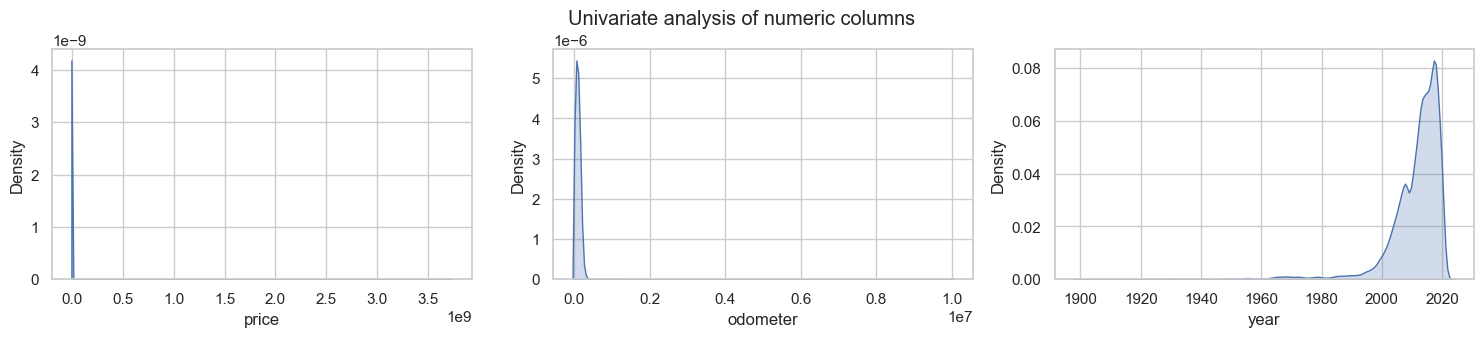

In [130]:
# Univariate analysis of numeric columns
numericCols = ['price', 'odometer', 'year']
plt.figure(figsize=(15, 15))
plt.suptitle("Univariate analysis of numeric columns")
for col in range(len(numericCols)):
    plt.subplot(5,3,col+1)
    sns.kdeplot(x = cars[numericCols[col]], shade=True)
    plt.xlabel(numericCols[col])
    plt.tight_layout()


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

**VIN number of a vehicle doesn't help predict the price of the car. Hence, we can get rid of the vin column.**

In [131]:
cars.drop('VIN', inplace = True, axis=1)

A column with more than 70% of the null values also doesn't help in determining the price. Hence, eliminating the column size.

In [133]:
cars.drop('size', inplace=True, axis=1)

KeyError: "['size'] not found in axis"

#### Outlier determination and elimination

<Axes: >

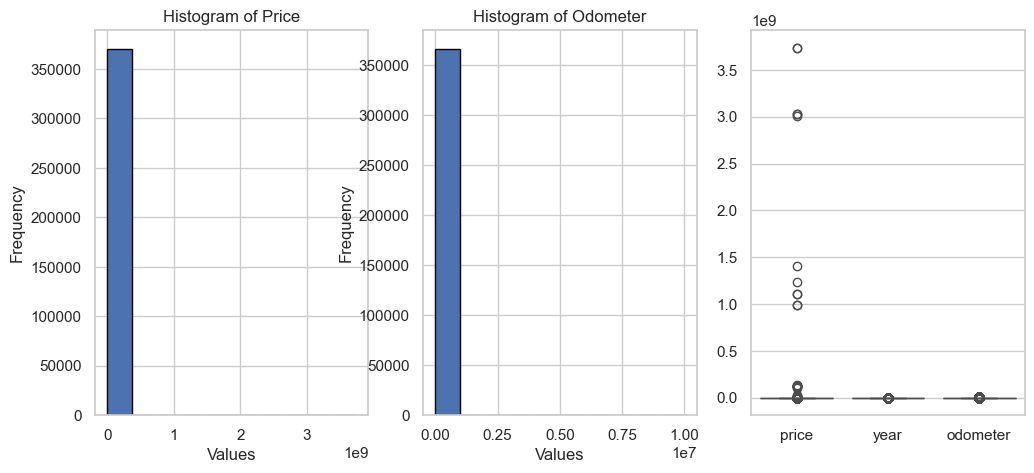

In [134]:
carsOriginal = cars # Just assigning to a new variable so that cleaned data doesn't affect these graphs later on.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
carsOriginal['price'].hist(ax=axes[0], bins=10, edgecolor='black')
axes[0].set_title('Histogram of Price')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
carsOriginal['odometer'].hist(ax=axes[1], bins=10, edgecolor='black')
axes[1].set_title('Histogram of Odometer')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
sns.boxplot(data=cars)

The histograms definitely show that there are lot of outliers in price and odometer. Since these two are the only non- categorical features, we care about outliers in only these two columns. The next step eliminates the outliers from those two features. 

In [135]:
def eliminateoutliers(col, dataset):
    df=dataset[[col]]
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the IQR for each column
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Detect outliers using IQR for each column
    outliers_iqr = ((df < lower_bound) | (df > upper_bound)).any(axis=1)
    return dataset[~outliers_iqr]

In [136]:
print("Total cars before outlier removal:", len(cars))
cars = eliminateoutliers('price', cars)
print("Total cars after removing price outliers", len(cars))
cars = eliminateoutliers('odometer', cars)
print("Total cars after removing odometer outliers", len(cars))

Total cars before outlier removal: 370678
Total cars after removing price outliers 363843
Total cars after removing odometer outliers 360155


<Axes: >

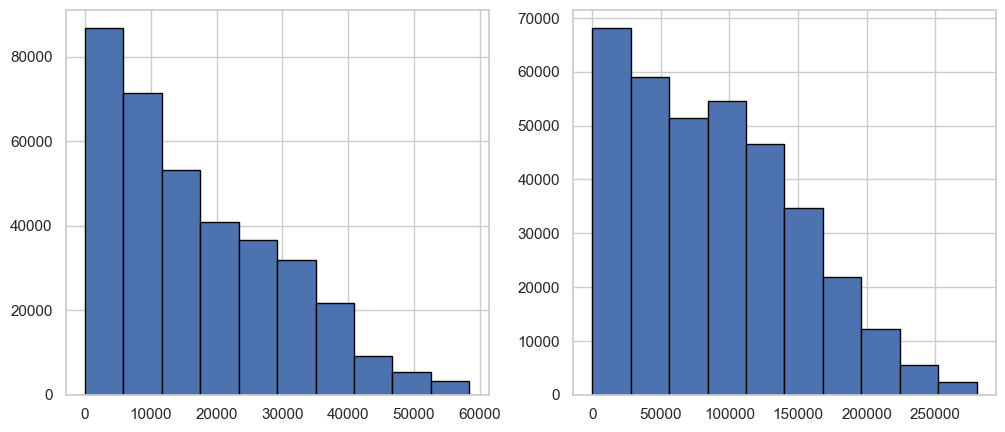

In [137]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
cars['price'].hist(ax=axes[0], bins=10, edgecolor='black')
cars['odometer'].hist(ax=axes[1], bins=10, edgecolor='black')

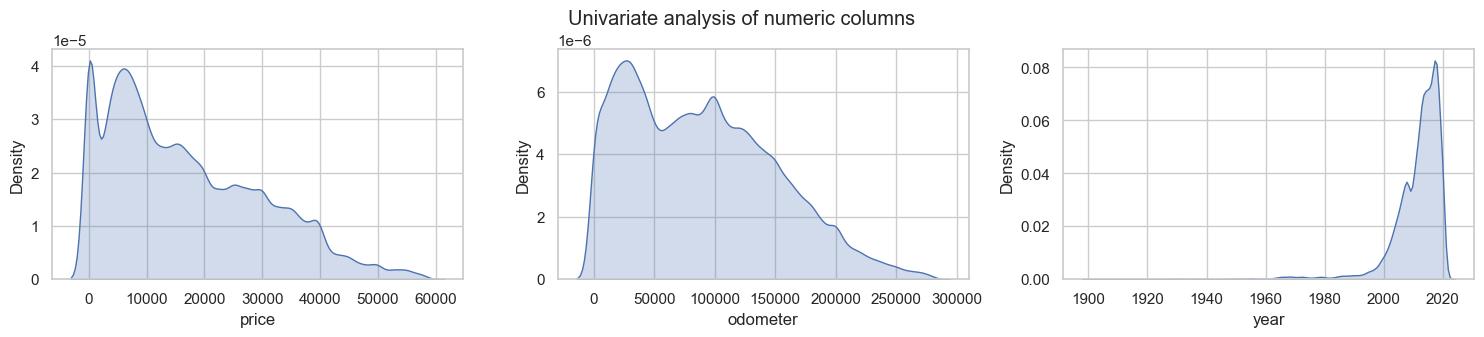

In [138]:
numericCols = ['price', 'odometer', 'year']
plt.figure(figsize=(15, 15))
plt.suptitle("Univariate analysis of numeric columns")
for col in range(len(numericCols)):
    plt.subplot(5,3,col+1)
    sns.kdeplot(x = cars[numericCols[col]], shade=True)
    plt.xlabel(numericCols[col])
    plt.tight_layout()

#### Observations after outlier removal

After eliminating the outliers from the dataset, there is a significant difference in the histograms of price and odometers and the KDE plots also show that the data is somewhat evenly distributed compared to before removing outlers.

#### Null Handling

We noticed before that there are some columns with very few nulls. we are dropping those columns altogether. But for other columns where we have significant nulls, we can replace them with most frequently occurring value. 

In [139]:
specific_column = 'year'
cars = cars.dropna(subset=[specific_column])
specific_column = 'transmission'
cars = cars.dropna(subset=[specific_column])
specific_column = 'fuel'
cars = cars.dropna(subset=[specific_column])
specific_column = 'model'
cars = cars.dropna(subset=[specific_column])

In [140]:
# for Odometer, we can take mean of odometer values to fill in the null value. 
cars['odometer'].fillna(math.ceil(np.mean(cars['odometer'])), inplace=True)

In [142]:
cars['condition'].fillna("good", inplace=True)
cars['manufacturer'].fillna('ford', inplace=True)
cars['cylinders'].fillna('6 cylinders', inplace=True)
cars['fuel'].fillna('gas', inplace=True)
cars['title_status'].fillna('clean', inplace=True)
cars['drive'].fillna('4wd', inplace=True)
cars['type'].fillna('sedan', inplace=True)
cars['paint_color'].fillna('white', inplace=True)

In [143]:
cars.isnull().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

**Null Handling Observation**
After removing the null values, it can be seen above that there are no more null values in the total data set, and also we don't have a significant loss of data as we imputed some columns with some other data. 

**More Graphs for observing correlations**
1. Price Vs Condition
2. Price Vs Year
3. Price Vs Cylinders 

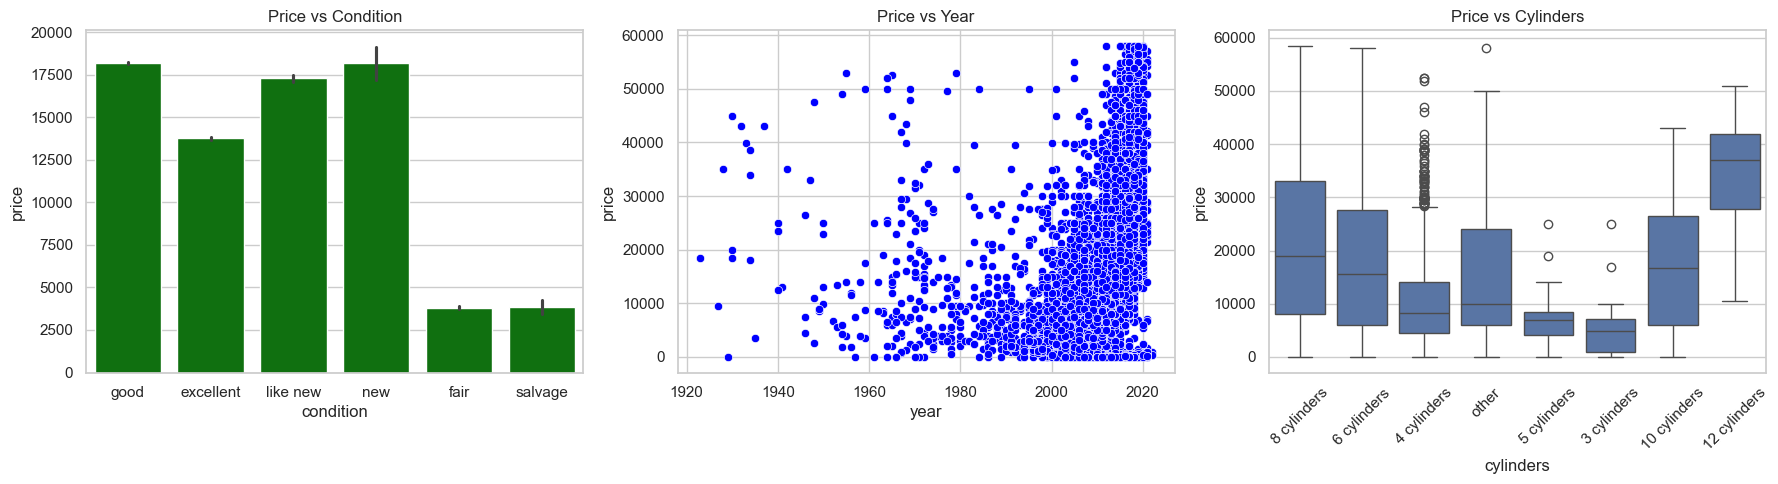

In [144]:
df_sorted = cars.sort_values(by='price')
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=df_sorted['condition'], y=df_sorted['price'], data=df_sorted.sample(10000), ax=axes[0], color='green')
axes[0].set_title('Price vs Condition')
sns.scatterplot(x='year', y='price', data=cars.sample(10000), ax=axes[1], color='blue')
axes[1].set_title('Price vs Year')
sns.boxplot(x='cylinders', y='price', data=cars.sample(10000), ax=axes[2])
axes[2].set_title('Price vs Cylinders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations from above graph**

When taken a sample size of 10000, we can observe that the price of car is somewhat correlatable to condition and year i.e. newer vehicles, like new vehiles and good conditioned vehicles are higher priced than fair and salvage vehicles as expected. 

**Convert Non-numeric data to numeric data using Label Encoding**
Non-numeric data such as cylinders, region, manufacturer, model etc. cannot be used to find correlation or to plot pair plots. Hence, we need to convert the data into numeric data. Two ways of doing that are using: 
1. Label Encoding
2. One Hot Encoding

I chose Label Encoding because one hot encoding creates a lot more features to work with. Owing to the size of data and systems we are using, Label encoding is my preferred way. 

In [145]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
cars_numeric_labels = cars.apply(labelEncoder.fit_transform)

In [146]:
cars_numeric_labels.sample(15)

region  price  year  manufacturer  model  condition  cylinders  fuel  \
37542      220   2271    94            38   9039          0          3     2   
29252      149  11522   103            13  13122          0          5     2   
169526     390   6673    98            34  23826          2          5     2   
192870     396   6878    99            13  16969          2          3     0   
409484     312   9052   105            36  14933          3          3     2   
132860      33   3986   104            21  15056          2          5     2   
181360      20   2275   101             7  10757          2          5     2   
164152     166   2806   102            13  11753          2          6     2   
418577     169   1194    94            13   5990          3          3     2   
10314      269   6712   105             7  12354          2          5     2   
287840       2   1831    98             7  10777          2          5     2   
171634     191  10446   106            30  15190          2          5     2   
136954     340  10444   106             3  20419          2          3     2   
148243     347    478   101            13   4091          3          5     2   
36679      220   7129   104            16   7286          2          5     2   

        odometer  title_status  transmission  drive  type  paint_color  state  
37542      59732             0             0      0     9           10      4  
29252      53154             0             0      0     9           10      4  
169526     55600             0             0      0     9           10     16  
192870     79502             0             0      2    10            1     19  
409484     21659             0             0      0     0           10     47  
132860     26583             0             0      0     9           10     13  
181360     45518             0             0      0     9           10     20  
164152     89969             0             0      0     9           10     16  
418577     51089             0             1      1     9           10     48  
10314      10932             0             2      1     7            0      3  
287840     69495             0             1      0     9           10     35  
171634     13645             0             0      0     8            8     17  
136954     13942             0             0      0     0           10     13  
148243     26492             0             0      0     9           10     14  
36679      27810             0             2      1     9           10      4

In [147]:
# labelEncoder.inverse_transform([14]) # here since label encoder is only persisting the last column, inverse transforming will return the state name for the encoded value. 

**Encoding Notes**
After using Label Encoding from SK Learn, we could see that all the above data is now transformed into numeric data. 

#### Correlation Matrix and Heat maps


In [151]:
print(cars_numeric_labels.info())

<class 'pandas.core.frame.DataFrame'>
Index: 351547 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   region        351547 non-null  int32
 1   price         351547 non-null  int64
 2   year          351547 non-null  int64
 3   manufacturer  351547 non-null  int32
 4   model         351547 non-null  int32
 5   condition     351547 non-null  int32
 6   cylinders     351547 non-null  int32
 7   fuel          351547 non-null  int32
 8   odometer      351547 non-null  int64
 9   title_status  351547 non-null  int32
 10  transmission  351547 non-null  int32
 11  drive         351547 non-null  int32
 12  type          351547 non-null  int32
 13  paint_color   351547 non-null  int32
 14  state         351547 non-null  int32
dtypes: int32(12), int64(3)
memory usage: 26.8 MB
None


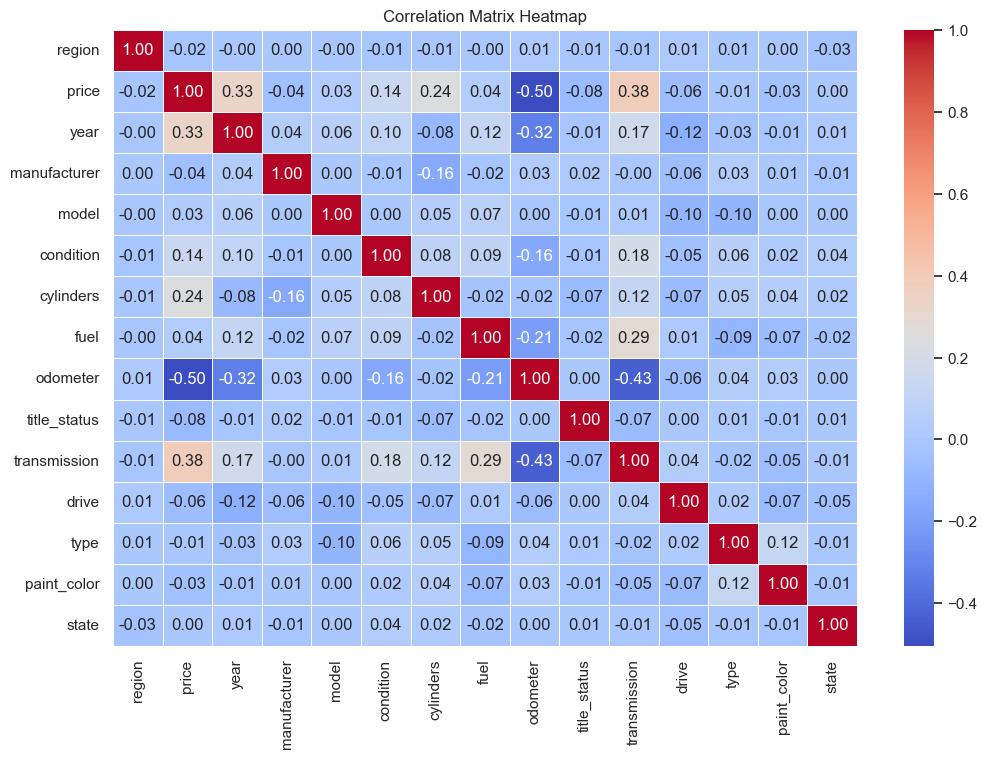

In [152]:
correlation_matrix = cars_numeric_labels.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

**Correlation Matrix Notes:**
From the above matrix, we can observe that the odometer, transmission and year have higher correlation to price compared to other features as expected. 

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [156]:
X = cars_numeric_labels.drop('price', axis=1) # dropping price since that is our target.
y = cars_numeric_labels['price'] # Setting prices as target.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linReg = LinearRegression().fit(X_train, y_train)

print("score =", linReg.score(X_test, y_test)) # this is the base performance of the existing data set.
print("mse = ", mean_squared_error(y_test, linReg.predict(X_test)))


score = 0.38111510508275737
mse =  10899923.433252282


In [157]:
stdScalar = StandardScaler()
scaledData = stdScalar.fit_transform(cars_numeric_labels)
scaledData

array([[-1.5103583 ,  1.35017739,  0.29574286, ...,  0.36061936,
         0.77215337, -1.50413036],
       [-1.5103583 ,  0.61182424, -0.13473237, ...,  0.36061936,
        -1.47664911, -1.50413036],
       [-1.5103583 ,  1.62262804,  0.94145571, ...,  0.36061936,
         0.27241948, -1.50413036],
       ...,
       [ 1.72883113,  1.4396459 ,  0.94145571, ..., -0.71009443,
         0.77215337,  1.74281892],
       [ 1.72883113,  1.0898621 ,  0.7262181 , ...,  0.62829781,
         0.52228643,  1.74281892],
       [ 1.72883113,  1.18361368,  0.8338369 , ..., -0.97777288,
         0.77215337,  1.74281892]])

#### PCA Analysis
PCA Analysis with 3 components

In [158]:
pca = PCA(n_components = 3)
pca.fit(scaledData)

PCA(n_components=3)

In [159]:
X_pcaTrain = pca.transform(scaledData)
print(X_pcaTrain.shape)

(351547, 3)


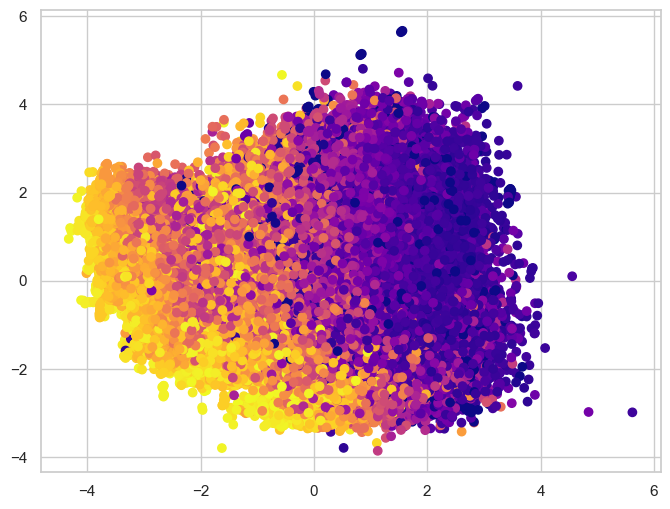

In [160]:
plt.figure(figsize=(8,6))
plt.scatter(X_pcaTrain[:,0], X_pcaTrain[:, 1], c=cars_numeric_labels['price'], cmap='plasma')


In [161]:
X = X_pcaTrain
y = cars_numeric_labels['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linReg = LinearRegression().fit(X_train, y_train)
linReg.score(X_test, y_test)

0.6046275428814843

**Observations of PCA Analysis**
Compared to base data without standard scalar applied, the Linear regression performed on a PCA data results in a better score.

In [162]:
params_dict = {'alpha': [0.1, 1.0, 10.0]}
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)

In [110]:
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
grid.fit(X_train, y_train)
train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)
train_mse = mean_squared_error(y_train, train_preds)
test_mse = mean_squared_error(y_test, test_preds)

In [111]:
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 7308298.150665874
Test MSE: 7359197.82302067


In [113]:
ridge = Ridge()
grid = GridSearchCV(ridge, param_grid=params_dict)
grid.fit(X_train, y_train)
best_alpha = grid.best_params_
print(f'Best alpha: {list(best_alpha.values())[0]}')

Best alpha: 10.0


In [114]:
pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])
param_dict = {'ridge__alpha': [0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid_2 = GridSearchCV(pipe, param_grid=param_dict)
grid_2.fit(X_train, y_train)
train_preds = grid_2.predict(X_train)
test_preds = grid_2.predict(X_test)
model_2_train_mse = mean_squared_error(y_train, train_preds)
model_2_test_mse = mean_squared_error(y_test, test_preds)
model_2_best_alpha = grid_2.best_params_
### END SOLUTION

# Answer check
print(f'Test MSE: {model_2_test_mse}')
print(f'Best Alpha: {list(model_2_best_alpha.values())[0]}')

Test MSE: 7359199.109103569
Best Alpha: 1.0


In [166]:
def simple_cross_validation(X_train, y_train, X_test, y_test):
    best_pipe = None #placeholder for best model
    best_mse = np.inf #set best mse to infinity to begin
    for i in range(1, 10):
        pipe = Pipeline([
            ('pfeat', PolynomialFeatures(degree = i, include_bias=False)),
            ('linreg', LinearRegression())
        ])
        pipe.fit(X_train, y_train)
        test_preds = pipe.predict(X_test)
        test_mse = mean_squared_error(y_test, test_preds)
        print(test_mse)
        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
    return best_pipe
### END SOLUTION

best_model = simple_cross_validation(X_train, y_train, X_test, y_test)
best_model.get_params()

6963378.078220689
6178885.990713184
5899903.019642405
5752733.350313511
5630026.677291257
5579554.134137827
5515063.310508141
5493444.659499045
5572705.637394546


{'memory': None,
 'steps': [('pfeat', PolynomialFeatures(degree=8, include_bias=False)),
  ('linreg', LinearRegression())],
 'verbose': False,
 'pfeat': PolynomialFeatures(degree=8, include_bias=False),
 'linreg': LinearRegression(),
 'pfeat__degree': 8,
 'pfeat__include_bias': False,
 'pfeat__interaction_only': False,
 'pfeat__order': 'C',
 'linreg__copy_X': True,
 'linreg__fit_intercept': True,
 'linreg__n_jobs': None,
 'linreg__positive': False}

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.